In [4]:
%matplotlib inline
import pandas as pd
import pickle
import plotly.express as px
from tqdm import tqdm
import csv

pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 400)
pd.set_option("display.max_colwidth", None) # None for all of it
PARTYCOLORS =  {'AfD': '#59dcff', "CSU":"#525060", "CDU":"black", "CDU/CSU":"black","SPD":"#e03427", "GRUENE":"#52d157", "GRÜNE":"#52d157", "DIE LINKE":"#a33ab5", "FDP":"#ffeb3b",}

# Imports for BERTopic

from bertopic.representation import MaximalMarginalRelevance
from umap import UMAP
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic

In [5]:
BUNDESLAND = "hh"

In [6]:
# Import selected sentences and select electoral period 19
stc = pd.read_feather(f"data/{BUNDESLAND}_climate.feather")
stc = stc[stc["electoral_term"] == sorted(list(stc["electoral_term"].unique()))[-1]]
stc = stc.reset_index()
stc.shape

(2074, 14)

In [8]:
stc.party.unique()

array(['DIE LINKE', 'AfD', 'CDU', 'SPD', 'GRÜNE'], dtype=object)

In [9]:
from sentence_transformers import SentenceTransformer

## Prepare embeddings
# Small sentence transformer
# sentence_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
# Large sentence transformer
sentence_model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')

In [10]:
## Only needs to be done once
#speeches = stc["sentence"].to_list()
#embeddings = sentence_model.encode(speeches)

#with open(f'data/topic_modeling/mpnet-base-v2_{BUNDESLAND}.pickle', 'wb') as pkl:
#    pickle.dump(embeddings, pkl)

In [11]:
# Load embeddings from pickle
speeches = stc["sentence"].to_list()
with open(f'data/topic_modeling/mpnet-base-v2_{BUNDESLAND}.pickle', 'rb') as pkl:
    embeddings = pickle.load(pkl)
len(speeches)

2074

In [12]:
# Count documents of each party in each topic
def count_topic_by_party(dftm):
    dfcount = pd.DataFrame(dftm.groupby(["party", "Topic"])["Document"].count()).reset_index()
    missing_count = []
    
    for party in dftm.party.unique().tolist():
        for i in range(max(topic_model.topic_sizes_.keys())+1):
            if len(dfcount[(dfcount["party"] == party) & (dfcount["Topic"] == i)]) == 0:
                missing_count.append([party, i, 0])
    
    missingdf = pd.DataFrame(missing_count, columns=['party','Topic','Document'])
    dfcount = pd.concat([dfcount, missingdf]).reset_index()
    return dfcount

In [13]:
def fit_model(params):
    umap_model = UMAP(n_neighbors=params["umap_n_neigh"], n_components=params["umap_n_comp"], metric='cosine', random_state=params["random_state"], low_memory=False)
    
    # Create representation model
    representation_model = MaximalMarginalRelevance(diversity=0.15, top_n_words=15)
    
    # Vectorizer to remove german stop words from representation
    german_stop_words = stopwords.words('german')
    vectorizer_model = CountVectorizer(stop_words = german_stop_words)
    
    topic_model = BERTopic(representation_model=representation_model, vectorizer_model=vectorizer_model, umap_model=umap_model, 
                           embedding_model=sentence_model, top_n_words=12, min_topic_size=params["min_topic_size"])

    topics, probs = topic_model.fit_transform(speeches, embeddings)
    
    return topic_model, topics, probs

In [14]:
def results_summary(stc, speeches, topics, outlier_reduced=False):
    # Results as dataframe
    dftm = pd.DataFrame({"Document": speeches, "Topic": topics})
    dftm = dftm.join(stc.party).join(stc.session).join(stc.speech_id).join(stc.sent_id)
    #dftm.sample()
    
    dfcount = count_topic_by_party(dftm)
    
    dfcount["total"] = dftm.party.value_counts()[dfcount["party"]].reset_index()["count"]
    dfcount["topic_salience"] = dfcount["Document"] / dfcount["total"]
    dfcount["salience_sum"] = dfcount.Topic.map(dfcount.groupby("Topic").topic_salience.sum())
    dfcount["salience_normalized"] = dfcount["topic_salience"] / dfcount["salience_sum"]
    dfcount["std_sal_normalized"] = dfcount.Topic.map(dfcount.groupby("Topic")["salience_normalized"].std())
    dfcount.loc[:,"mean_normalized"] = dfcount.Topic.map(dfcount.groupby("Topic").salience_normalized.mean())
    dfcount.loc[:,"sal_diff"] = abs(dfcount["salience_normalized"] - dfcount["mean_normalized"])
    
    #percentage of outliers
    percentage_outlier = dfcount[dfcount["Topic"] == -1]["Document"].sum()/len(speeches)
    
    # Mean std deviation of normalized topic salience 
    import statistics
    sal_std = statistics.mean(dfcount[(dfcount["Topic"]>-1)].groupby("Topic")["salience_normalized"].std())

    params["num_topics"] = dftm.Topic.nunique()
    params["perc_outlier"] = f"{(percentage_outlier):.4f}"
    params["max_topic_count"] = dftm[dftm["Topic"]>-1].Topic.value_counts().max()
    params["sal_std"] = f"{(sal_std):.4f}"
    params["top_sal_diff"] = dfcount.sort_values("sal_diff").tail(20).sal_diff.mean()
    params["high_sal_diff_perc_of_topic"] = f"{(dfcount[dfcount["sal_diff"] > 0.2].party.value_counts().sum() / params["num_topics"]):.4f}"
    params["top_party_high_sal_diff"] = dfcount.sort_values("sal_diff").tail(20).party.value_counts().max()
    params["outlier_reduced"] = outlier_reduced
    
    ## Only needed for hyperparameter tuning
    #with open(f"data/topic_modeling/bertopic_params_{BUNDESLAND}.csv", "a", newline="") as f:
    #    w = csv.DictWriter(f, params.keys())
    #    w.writerow(params)

    return dftm, dfcount

In [37]:
# Hyperparameter tuning
for n in tqdm([3,4,5,6,7]):
    for s in [8,10,12]:
        for rs in [2,18,42,41,43,45,99]:
            params = {"umap_n_neigh":n, "umap_n_comp": 5, "min_topic_size":s, "random_state": rs}
            # Do the modelling
            topic_model, topics, probs = fit_model(params)
            results_summary(stc, speeches, topics)
            
            # testing outlier reduction at different threshholds
            for thr in [0.75,0.7]:
                try:
                    tps = topic_model.reduce_outliers(speeches, topics , strategy="embeddings", embeddings=embeddings, threshold=thr)
                    dftm, dfcount = results_summary(stc, speeches, tps, outlier_reduced=True)
                except:
                    pass

  0%|                                                                                                            | 0/5 [00:02<?, ?it/s]

KeyboardInterrupt



In [51]:
# Evaluation of parameter tuning
hp = pd.read_csv(f"data/topic_modeling/bertopic_params_{BUNDESLAND}.csv", header=None)
hp = hp.set_axis(params.keys(), axis=1)
#hp.mean()
hp = hp[hp["outlier_reduced"]]
hp = hp[hp["min_topic_size"] == 8]

In [52]:
hp.groupby(["umap_n_neigh","min_topic_size"]).mean()

umap_n_comp  random_state  num_topics  \
umap_n_neigh min_topic_size                                          
3            8                       5.0     41.428571   46.714286   
4            8                       5.0     41.428571   46.571429   
5            8                       5.0     41.428571   37.571429   
6            8                       5.0     41.428571   31.857143   
7            8                       5.0     41.428571   32.428571   

                             perc_outlier  max_topic_count   sal_std  \
umap_n_neigh min_topic_size                                            
3            8                   0.091250       658.142857  0.144136   
4            8                   0.138857       321.142857  0.144593   
5            8                   0.142614       338.428571  0.139779   
6            8                   0.135014       352.928571  0.131514   
7            8                   0.147379       324.285714  0.133279   

                             top_sal_diff  high_sal_diff_perc_of_topic  \
umap_n_neigh min_topic_size                                              
3            8                   0.277245                     0.543607   
4            8                   0.308636                     0.432257   
5            8                   0.284270                     0.366679   
6            8                   0.252978                     0.330507   
7            8                   0.252528                     0.335550   

                             top_party_high_sal_diff  outlier_reduced  
umap_n_neigh min_topic_size                                            
3            8                              5.571429              1.0  
4            8                              6.071429              1.0  
5            8                              5.857143              1.0  
6            8                              6.000000              1.0  
7            8                              6.214286              1.0

In [ ]:
hp = hp[hp["umap_n_neigh"] == 4]
hp

In [13]:
hp.shape

(105, 12)

In [15]:
params = {"umap_n_neigh":4, "umap_n_comp": 5, "min_topic_size":8, "random_state": 2}

# Do the modelling
topic_model, topics, probs = fit_model(params)
dftm, dfcount = results_summary(stc, speeches, topics)

tps = topic_model.reduce_outliers(speeches, topics , strategy="embeddings", embeddings=embeddings, threshold=0.7)
dftm, dfcount = results_summary(stc, speeches, tps, outlier_reduced=True)

# Overview Topics

In [18]:
print("Number of sentences:", dfcount.Document.sum())
print("Number of Topics:", dfcount["Topic"].max())
print("Size smallest and biggest Topic:", dftm[dftm["Topic"]>-1].Topic.value_counts().min(), dftm[dftm["Topic"]>-1].Topic.value_counts().max())
print("% outlier", dfcount[dfcount["Topic"] == -1]["Document"].sum()/dfcount["Document"].sum())

Number of sentences: 2074
Number of Topics: 39
Size smallest and biggest Topic: 11 360
% outlier 0.09498553519768563


In [19]:
# Save all topic representations to table
topic_model.get_topic_info()[["Topic", "Count", "Representation", "Representative_Docs"]].to_csv(f"overview_topics_{BUNDESLAND}_{sorted(list(stc["electoral_term"].unique()))[-1]}.csv", index=False)

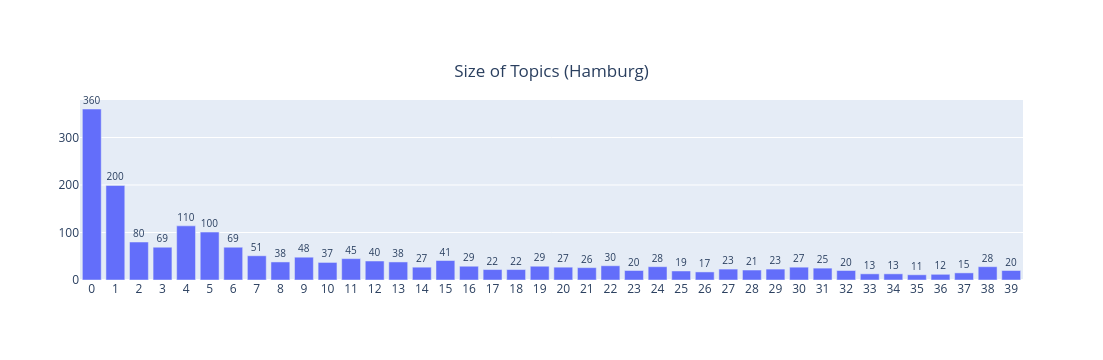

In [31]:
fig = px.bar(dftm[~(dftm["Topic"]==-1)].Topic.value_counts(), title="Size of Topics (Hamburg)", text_auto='.2s')
fig.update_layout(title_x=0.5, title_y=0.82, showlegend=False, xaxis_title=None, yaxis_title=None)
fig.update_layout(xaxis=dict(tickvals=list(range(0, dfcount["Topic"].nunique()))))
fig.update_traces(textfont_size=10, textangle=0, textposition="outside", cliponaxis=False)
fig.show()

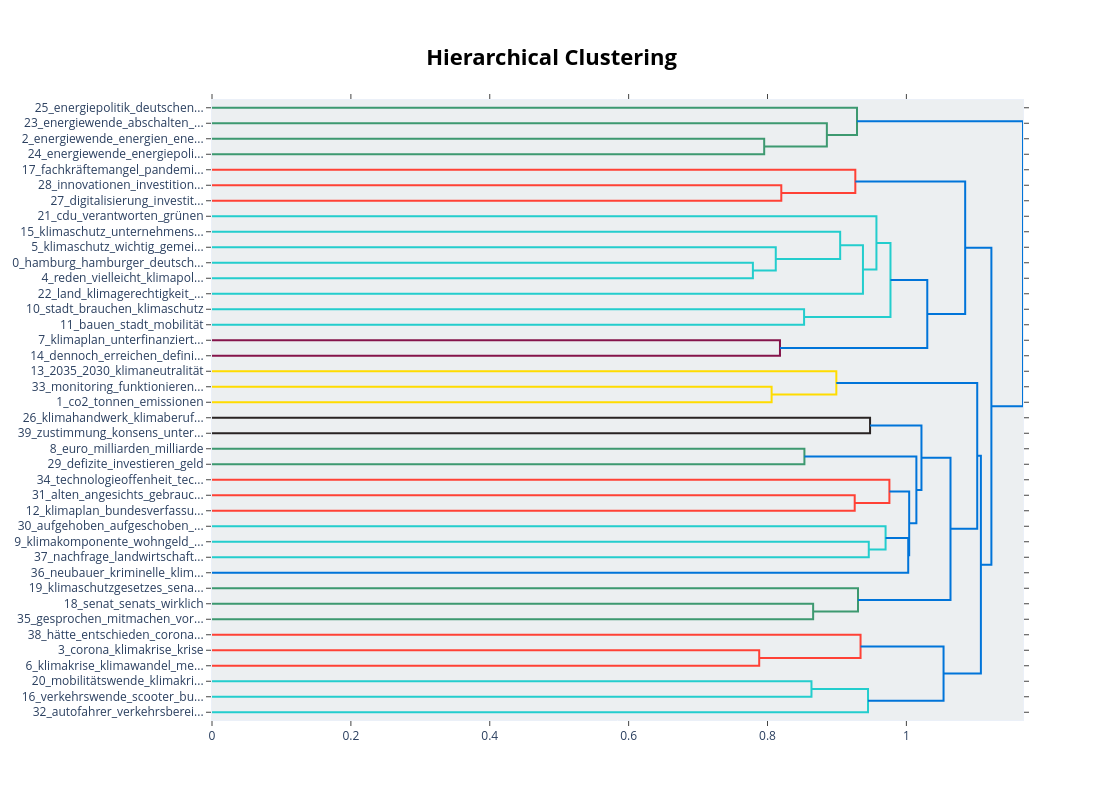

In [60]:
topic_model.visualize_hierarchy()

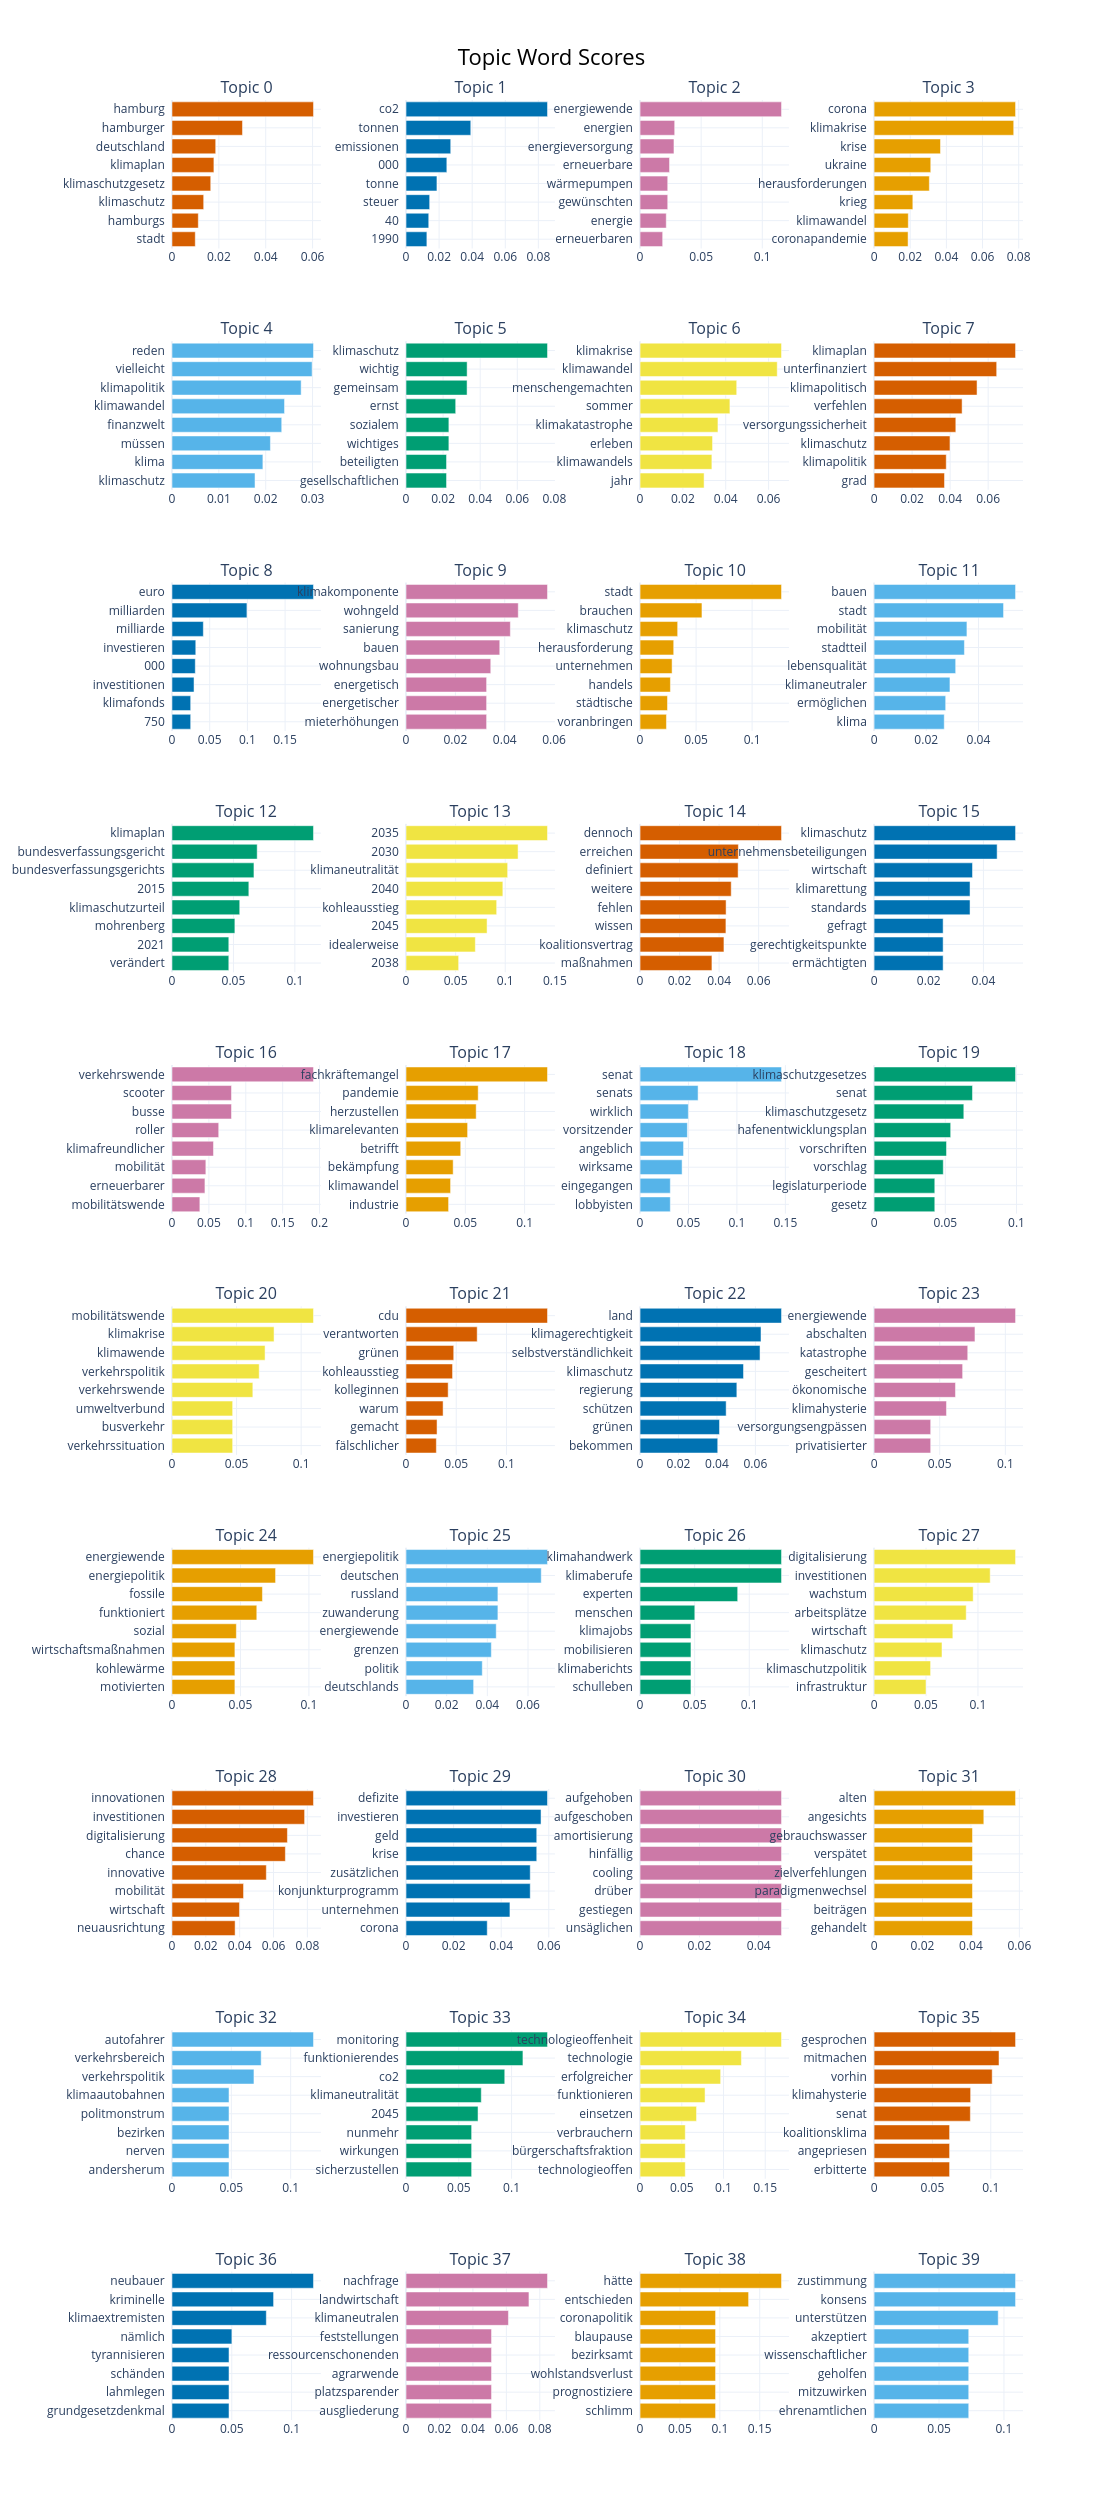

In [64]:
topic_model.visualize_barchart(top_n_topics = 87, n_words = 8)

# Topic salience Party Comparison

In [14]:
dfcount[dfcount["salience_normalized"] > 0.35].party.value_counts()

party
AfD          7
CDU          5
SPD          5
DIE LINKE    4
GRÜNE        4
Name: count, dtype: int64

In [37]:
dfcount[dfcount["Topic"] == 3]

index      party  Topic  Document  total  topic_salience  salience_sum  \
4        4        AfD      3        11    372        0.029570       0.16698   
38      38        CDU      3         3    247        0.012146       0.16698   
72      72  DIE LINKE      3        12    429        0.027972       0.16698   
108    108      GRÜNE      3        37    584        0.063356       0.16698   
145    145        SPD      3        15    442        0.033937       0.16698   

     salience_normalized  std_sal_normalized  mean_normalized  sal_diff  
4               0.177086             0.11178              0.2  0.022914  
38              0.072738             0.11178              0.2  0.127262  
72              0.167517             0.11178              0.2  0.032483  
108             0.379423             0.11178              0.2  0.179423  
145             0.203237             0.11178              0.2  0.003237

In [21]:
# Salience not normalized
graphdf1 = dfcount[(dfcount.Topic < 20) & (dfcount["Topic"] > -1) ]
graphdf2 = dfcount[(dfcount.Topic >= 20)]
#fig = px.bar(graphdf1, x="Topic", y="topic_salience", color="party", barmode='group', color_discrete_map=PARTYCOLORS, title="Topic salience")
#fig.show()
#fig = px.bar(graphdf2, x="Topic", y="topic_salience", color="party", barmode='group', color_discrete_map=PARTYCOLORS, title="Topic salience")
#fig.show()

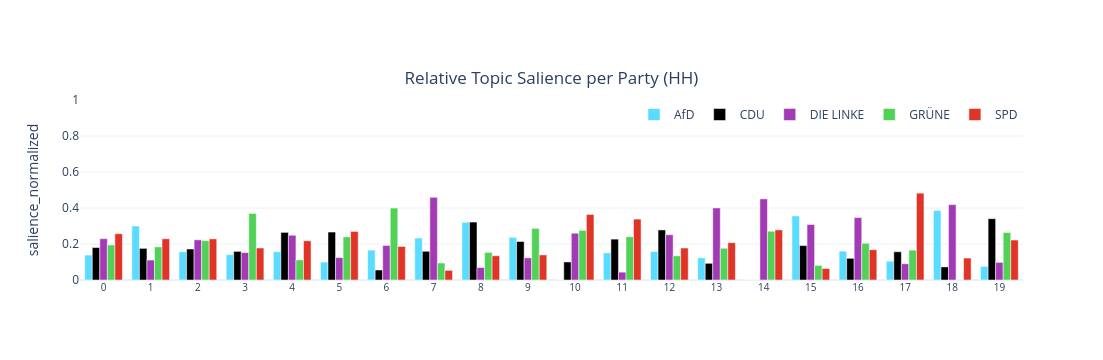

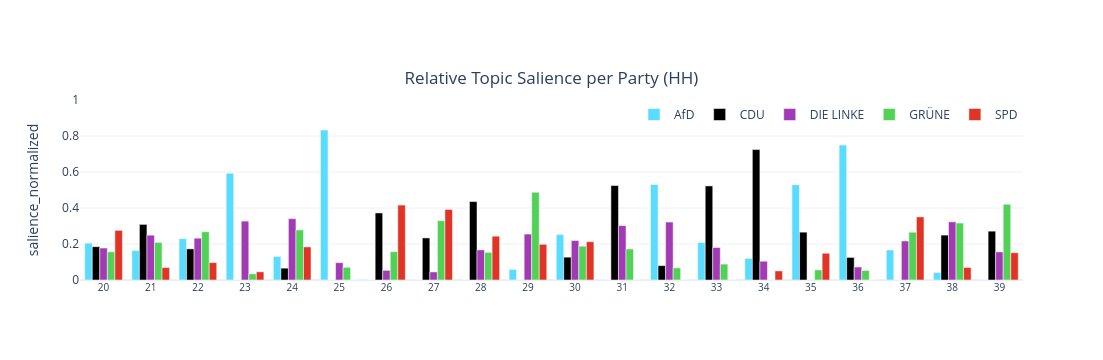

In [22]:
# Salience normalized
fig = px.bar(graphdf1, x="Topic", y="salience_normalized", color="party", range_y=[0,1], barmode='group', template="plotly_white", color_discrete_map=PARTYCOLORS, title=f"Relative Topic Salience per Party ({BUNDESLAND.upper()})").update_layout(title_x=0.5, title_y=0.8, legend=dict(yanchor="top", y=1, xanchor="right", x=1, orientation='h', title=""), xaxis_title=None)
fig.update_layout(xaxis=dict(tickfont_size=10, tickvals=list(range(-1, graphdf1["Topic"].nunique()+1))))
fig.show()
fig = px.bar(graphdf2, x="Topic", y="salience_normalized", color="party", range_y=[0,1], barmode='group', template="plotly_white", color_discrete_map=PARTYCOLORS, title=f"Relative Topic Salience per Party ({BUNDESLAND.upper()})").update_layout(title_x=0.5, title_y=0.8, legend=dict(yanchor="top", y=1, xanchor="right", x=1, orientation='h', title=""), xaxis_title=None)
fig.update_layout(xaxis=dict(tickfont_size=10, tickvals=list(range(graphdf2["Topic"].unique().min(), graphdf2["Topic"].unique().max()+1))))
fig.show()

# Detailed Topic inspection

In [48]:
selection_high = dfcount[dfcount["salience_normalized"] > 0.45]
topicsh = selection_high.Topic.unique()
info = topic_model.get_topic_info()
info = info[info["Topic"].isin(topicsh)]
info = pd.merge(info, selection_high[["Topic","party", "salience_normalized"]])
info.head(1)

Topic  Count                                                  Name  \
0      7     37  7_klimaplan_unterfinanziert_klimapolitisch_verfehlen   

                                                                                                                                                  Representation  \
0  [klimaplan, unterfinanziert, klimapolitisch, verfehlen, versorgungssicherheit, klimaschutz, klimapolitik, grad, wissen, klimagerechtigkeit, stadt, riskieren]   

                                                                                                                                                                                                                                                                                                                                                                                                                                       Representative_Docs  \
0  [Das ist klimapolitisch nicht begeisternd, aber wir müssen eben gucken, dass wir, während wir die klimapolitisch guten Punkte ausbauen, nicht die Versorgungssicherheit der Stadt gefährden., Der bestehende Klimaplan bleibt unterfinanziert und wird dem 1,5-Grad-Ziel nicht gerecht., Das wird dem Problem sicher nicht gerecht, denn der bestehende Klimaplan ist bereits jetzt unterfinanziert und wird so das Ziel der 1,5-Grad-Marke verfehlen.]   

       party  salience_normalized  
0  DIE LINKE              0.45936

In [50]:
selection_high.party.value_counts()

party
AfD          5
CDU          3
DIE LINKE    2
GRÜNE        1
SPD          1
Name: count, dtype: int64

In [46]:
info[info["party"] == "AfD"][["Topic", "Count", "salience_normalized", "Representation", "Representative_Docs"]].sort_values("salience_normalized", ascending=False)

Topic  Count  salience_normalized  \
4      25     15             0.832952   
11     36     10             0.749364   
3      23     15             0.593038   
7      32     12             0.530505   
10     35     10             0.529456   

                                                                                                                                                                                 Representation  \
4                                                      [energiepolitik, deutschen, russland, zuwanderung, energiewende, grenzen, politik, deutschlands, klimahysterie, grünen, gas, kommission]   
11                                       [neubauer, kriminelle, klimaextremisten, nämlich, tyrannisieren, schänden, lahmlegen, grundgesetzdenkmal, ließ, verschleiern, klimamärtyrern, hierbei]   
3   [energiewende, abschalten, katastrophe, gescheitert, ökonomische, klimahysterie, versorgungsengpässen, privatisierter, russlandukraine, unerträgliche, kernkraftwerken, klimaanstrengungen]   
7                            [autofahrer, verkehrsbereich, verkehrspolitik, klimaautobahnen, politmonstrum, bezirken, nerven, andersherum, wohnungsbaupolitik, neulich, freiheiten, lebenszeit]   
10                                                     [gesprochen, mitmachen, vorhin, klimahysterie, senat, koalitionsklima, angepriesen, erbitterte, angespannt, sprach, gelaufen, kaschiert]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         Representative_Docs  
4   [Übertriebene Klimahysterie, die solide Industriezweige dem Verfall preisgibt, eine Verkehrswende, die einseitig den motorisierten Individualverkehr benachteiligt, eine unsolide Ausgabenpolitik, eine Politik, die den Linksextremismus aus der Flora hofiert, eine Politik, die es nicht fertigbringt, den Staatsvertrag zwischen Schura und Hamburg zu lösen, eine Zuwanderung, die über der Quote liegt., Milliardenkosten für die sinnlose grüne Energiewende, einhergehend mit der Deindustrialisierung Deutschlands, Bauernproteste, die immer mehr zunehmen und denen sich die Spediteure anschließen, die Einbürgerungsreform, die den deutschen Pass zur Ramschware macht, die ungebremste illegale Migration, der Wunsch der Bevölkerung nach Neuwahlen, die Umfragewerte, bei denen Rot-Grün unter die Räder kommt, und die Bürger drohen, eine Alternative zu wählen., Und wenn die Arbeitnehmer dann noch erkennen müssen, wie ihre hart erarbeiteten Steuergelder mit vollen Händen zum Fenster rausgeworfen werden für eine völlig ungesteuerte Zuwanderung ohne Grenzen, ohne jede staatliche Kontrolle, für irrsinnige und unsinnige

In [35]:
info[info["party"] == "CDU"][["Topic", "Count", "salience_normalized", "Representation", "Representative_Docs"]].sort_values("salience_normalized", ascending=False)

Topic  Count  salience_normalized  \
7     34     11             0.724750   
4     31     12             0.525013   
6     33     11             0.522734   

                                                                                                                                                                      Representation  \
7  [technologieoffenheit, technologie, erfolgreicher, funktionieren, einsetzen, verbrauchern, bürgerschaftsfraktion, technologieoffen, einbindung, zunehmender, effektiv, gezielten]   
4                  [alten, angesichts, gebrauchswasser, verspätet, zielverfehlungen, paradigmenwechsel, beiträgen, gehandelt, verspätung, erfolgte, einsparungsüberträgen, störende]   
6                          [monitoring, funktionierendes, co2, klimaneutralität, 2045, nunmehr, wirkungen, sicherzustellen, gradlimit, regierungsbeteiligung, beigetragen, erfassen]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               Representative_Docs  
7                                                                                                                                                                                                                                                                     [Dann an der Stelle ist es doch wichtig, dass wir beim Klimaschutz darauf achten, dass wir die Dinge, die wir da anschieben – das gilt auch für die Maßnahmen ab 2030 –, technologieoffen gestalten, denn es nutzt nichts, wenn wir nur mit Verboten und mit einseitigen Dingen kommen, von denen Sie heute glauben, dass es auf jeden Fall wirken würde., Erfolgreicher Klimaschutz kann nur funktionieren durch Technologieoffenheit, gezielte Anreize und im Einklang mit der Ökonomie, und dafür wird sich die CDU-Bürgerschaftsfraktion auch weiter einsetzen., Erfolgreicher Klimaschutz kann nur funktionieren durch Technologieoffenheit, gezielten Anreizen unter breitem Einsatz marktwirtschaftlicher Instrumente sowie durch echte Einbindung der Gesellschaft.]  
4  [Dabei waren die alten Ziele doch anscheinend schon zu hoch und wurden nur mit CO2-Zertifikaten, alten Einsparungsüberträgen und Corona erreicht – soweit man das weiß, denn das Monitoring funktioniert nicht wirklich., Angesichts der Wichtigkeit und der guten Anmeldung dieses Themas war ich jetzt etwas irritiert, wie wenig Konkretes wirklich herausgekommen ist von Rot-Grün, denn rund um den Klimawandel haben wir natürlich erhebliche Probleme mit dem Wasser, sowohl Gebrauchswasser als auch Trinkwasser, denn wenn jetzt nicht gehandelt wird, kann es zu spät sein mit der Wasserversorgung., An den Beiträgen von eben ist mir aufgefallen, dass offenbar immer noch nicht in allen Köpfen die Erkenntnis angekommen ist, wie tiefgreifend einerseits die Transformation ist, vor der wir stehen, und vor allem, wie falsch es wäre, jetzt scheinbar störende Maßnahmen, die dem Klima und der Umwelt dienen, fallenzulassen, und andererseits, welche Riesenchance sich hinter dieser notwendigen Transformation verbirgt.]  
6                                                                 

In [47]:
info[info["party"] == "SPD"][["Topic", "Count", "salience_normalized", "Representation", "Representative_Docs"]].sort_values("salience_normalized", ascending=False)

Topic  Count  salience_normalized  \
2     17     19             0.482453   

                                                                                                                                                                      Representation  \
2  [fachkräftemangel, pandemie, herzustellen, klimarelevanten, betrifft, bekämpfung, klimawandel, industrie, herausforderungen, wärmepumpeneinbau, industriegebiete, geopolitischen]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        Representative_Docs  
2  [Mit solchen vermeintlich kleineren Projekten sorgen wir dafür, dass der Fachkräftemangel nicht zur Achillesferse beim Kampf gegen den Klimawandel wird., Wobei man dazu sagen muss, dass der Fachkräftemangel zum Beispiel im HoGa-Bereich, was meine Vorrednerin eben angesprochen hat, aber auch im klimarelevanten Handwerksbereich schon vorher ein großes Problem war und vermutlich in Zukunft noch sein wird., In den klimarelevanten Bereichen wie Fotovoltaik und Wärmepumpeneinbau ist dies eigentlich eine wünschenswerte Entwicklung, doch hier darf der Fachkräftemangel nicht zur Achillesferse beim Kampf gegen den Klimawandel werden.]

In [44]:
info[info["party"] == "GRÜNE"][["Topic", "Count", "salience_normalized", "Representation", "Representative_Docs"]].sort_values("salience_normalized", ascending=False)

Topic  Count  salience_normalized  \
5     29     12             0.487595   

                                                                                                                                 Representation  \
5  [defizite, investieren, geld, krise, zusätzlichen, konjunkturprogramm, unternehmen, corona, finanziert, staatlichem, verschuldung, mögliche]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  Representative_Docs  
5  [Es ist wichtig, dass wir Krisenmanagement unternehmen, das haben wir an sehr vielen Ecken getan, das werden wir weiterhin tun, aber ein Konjunkturprogramm muss ebenso Aspekte für Zukunftsinvestitionen setzen, und deswegen ist es richtig, dass der Klimaplan, der von diesem Senat in der letzten Wahlperiode verabschiedet worden ist, auch ausfinanziert wird., Besonders hervorheben möchte ich hier unsere Finanzierung des Klimaplans, die finanzielle Ausstattung der Wissenschaft in Hamburg samt Hochschulbau und das Konjunkturpaket für unsere Unternehmen und Selbstständigen, die – sehr wichtig – größtenteils unverschuldet in die Corona-Krise geraten sind und – da bin ich mir sehr sicher – mehrheitlich eine gute Chance auf einen Neustart haben., Wir sagen, wir wollen dieses Geld zuvorderst investieren in ambitionierten Klimaschutz, weil wir wissen, es gibt eine Corona-Krise, es gibt eine Wirtschaftskrise, aber es gibt auch eine Klimakrise, und wir müssen die Themen zusammendenken, weil wir sagen, wir wollen in eine umfassende Mobilitätswende investieren, weil wir sagen, wir wollen in die Bildung investieren, in die Kitas, aber insbesondere in den Schulbau mit 4 Milliarden Euro, mit 2,7 Milliarden Euro in den Hochschulbau.]

In [51]:
info[info["party"] == "DIE LINKE"][["Topic", "Count", "salience_normalized", "Representation", "Representative_Docs"]].sort_values("salience_normalized", ascending=False)

Topic  Count  salience_normalized  \
0      7     37              0.45936   
1     14     24              0.45072   

                                                                                                                                                  Representation  \
0  [klimaplan, unterfinanziert, klimapolitisch, verfehlen, versorgungssicherheit, klimaschutz, klimapolitik, grad, wissen, klimagerechtigkeit, stadt, riskieren]   
1       [dennoch, erreichen, definiert, weitere, fehlen, wissen, koalitionsvertrag, maßnahmen, wirkungsvolles, klimaschutzkompromiss, quantifizierbar, genügend]   

                                                                                                                                                                                                                                                                                                                                                                                                                                       Representative_Docs  
0  [Das ist klimapolitisch nicht begeisternd, aber wir müssen eben gucken, dass wir, während wir die klimapolitisch guten Punkte ausbauen, nicht die Versorgungssicherheit der Stadt gefährden., Der bestehende Klimaplan bleibt unterfinanziert und wird dem 1,5-Grad-Ziel nicht gerecht., Das wird dem Problem sicher nicht gerecht, denn der bestehende Klimaplan ist bereits jetzt unterfinanziert und wird so das Ziel der 1,5-Grad-Marke verfehlen.]  
1                                                                                                                                                                                                                                                                                    [1,5 Grad sind 1,5 Grad und nicht 1,75 Grad mit 67prozentiger Wahrscheinlichkeit., Sie wissen doch, was für das 1,5-Grad-Ziel da ist., Es geht um das 1,5‑Grad-Ziel.]

In [53]:
dftm[dftm["Topic"] == 37]

Document  \
150                                                                                                                           Es gibt nämlich sogar Studien von Unternehmensberatungen und wissenschaftliche Erkenntnisse, dass 30 Prozent unserer klimaschädlichen Emissionen global in unserem Ernährungs- und Landwirtschaftssystem liegen.   
565                                                                                                                            Anstatt das Wachstum des Hafens an die allererste Stelle zu setzen, die Wettbewerbsfähigkeit, kurz die wirtschaftliche Überlebensfähigkeit des Hafens, steht im Zentrum dieses Plans leider nur Klimaideologie.   
595                                                                                                                                                           Was wir wirklich brauchen, ist der dringend benötigte Umbau der Landwirtschaft hin zu einer klima- und ressourcenschonenden Landwirtschaft und kein parteipolitisches Geplänkel.   
700                                                                                 Wir wissen, dass wir sowohl in der industriellen wie in der landwirtschaftlichen Produktion und auch bei der auf fossile Brennstoffe konzentrierten Mobilität erhebliche CO2-Einsparungen vornehmen müssen, um unsere Ziele beim Klimaschutz zu erreichen.   
840                                                                                                                                     Es geht schlicht und ergreifend darum, die vorhandenen Potenziale moderner, effizienter, platzsparender und klimaneutraler Lieferungen auf der Letzten Meile zu heben, da, wo es geht und Sinn ergibt.   
904   Bei allem Respekt, wenn man sich einmal den weltweiten Markt für alle größeren Güter mit großen energieeffizienten Produktionsweisen anschaut, sehen wir sehr klar, dass weltweit die Nachfrage danach steigt, dass Güter klimaneutral, möglichst energieeffizient und mit möglichst wenigen ökologischen Folgekosten produziert werden.   
1071                                                                                                                                                                                      Doch wie ist dieser Spagat zu schaffen zwischen den aufkommenden Lieferaufkommen einerseits und der Einhaltung der Klimaziele auf der anderen Seite?   
1265                                                                                                                                                                          Eine Ausgliederung der Umsetzung der Klimaziele verstetigt diesen Missstand nur zusätzlich zugunsten steigender Meeresspiegel und ganzjähriger Außengastronomie.   
1332                                                                                                                                                                                                  Es gibt nämlich auch das Thema, dass wir eine Agrarwende und eine Ernährungswende zum Erreichen der Klimaschutzziele unbedingt brauchen.   
1651                                                                               Es bedeutet die Einhaltung der Klimaziele – das hatte die Kollegin gesagt –, dass 30 Prozent der CO2-Emissionen auf Nahrungsmittel zurückzuführen sind, und es bedeutet eben, dass die Einhaltung der Klimaziele sich auch auf unseren Tellern entscheidet.   
1652                                                                                                                                               Es ist erstaunlich, wie man aus richtigen Feststellungen letztendlich zu diesem Petitum gelangt, und es ist völlig richtig, dass eine falsche Landwirtschaftspolitik Klimaauswirkungen hat.   
1754                                                                                                                                        Sie fragt sich, wie sie mit globalen Megatrends, der Nachfrage nach klimaneutralen Produktionsprozessen und klimaneutralen Produkt